In [26]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
import os

 

In [27]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=81, out_features=810, bias=True),
                                  nn.Dropout(0.7),
                                  nn.Tanh()
                                  )
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=810, out_features=162, bias=True),
                                  nn.Dropout(0.7),
                                  nn.Tanh()
                                  )
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=162, out_features=54, bias=True),
                                  nn.Dropout(0.6),
                                  nn.Tanh()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=54, out_features=1, bias=True),
                                        nn.Tanh())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model=MLP().to(device)


In [28]:
#   average

import collections
fl_model=model
# print(fl_model.state_dict())
# teachers_models =[torch.load(f'/home/ysy/ysy/Fed-ReKD-dirs/MLP_DP_SGD/teacher{tea_num}/best.pth')  for  tea_num in  range(5)]
# worker_state_dict = [x.state_dict() for x in teachers_models]
# weight_keys = list(worker_state_dict[0].keys())
# fed_state_dict = collections.OrderedDict()
# for key in weight_keys:
#     key_sum = 0
#     for i in range(len(teachers_models)):
#         key_sum = key_sum + worker_state_dict[i][key]
#     fed_state_dict[key] = key_sum / len(teachers_models)
 
# fl_model.load_state_dict(fed_state_dict)
# print(fl_model)

In [29]:
process_dataset_x= pd.read_csv('/home/ysy/ysy/Fed-ReKD-dirs/process_dataset_x.csv',index_col=0)
process_dataset_y= pd.read_csv('/home/ysy/ysy/Fed-ReKD-dirs/process_dataset_y.csv',index_col=0)
XX= process_dataset_x
YY= process_dataset_y['logerror']
target=YY
scale=StandardScaler()
x=scale.fit_transform(XX) 
del XX,YY
x=np.array(x)
target=np.array(target)
import torch
import numpy as np
from opacus import PrivacyEngine
from tqdm import tqdm
# target
train_dataset = []
train_loader = []
from torch.utils.data import TensorDataset, DataLoader
train_dataset=TensorDataset(torch.tensor(x,dtype=torch.float),
                                    torch.tensor(target,dtype=torch.float))
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True)


In [30]:
from opacus.validators import ModuleValidator

errors = ModuleValidator.validate(fl_model, strict=False)
errors[-5:]

[]

In [31]:
from opacus import PrivacyEngine
import warnings
warnings.simplefilter("ignore")

 

privacy_engine = PrivacyEngine()
optimizer = torch.optim.SGD(fl_model.parameters(), lr=1e-4)
fl_model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=fl_model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=80,
    # target_epsilon=2,
    target_epsilon=4,
    # target_epsilon=6,
    target_delta=1e-5,
    max_grad_norm=2,
)
print(f"Using sigma={optimizer.noise_multiplier} ")

Using sigma=0.6536865234375 


In [32]:
loss_all=[]
epsilon_all=[]
delta=1e-5
loss_func = torch.nn.MSELoss()
minloss=float('inf')
import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager
for epoch in range(80):
    fl_model.train()
    train_loss = 0
    train_num=0
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=128, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        for data,target in memory_safe_data_loader:
            
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output =fl_model(data)
            loss = loss_func(output, target)
            # losses.append(loss.item())
            loss.backward()
            optimizer.step()
            train_loss+=loss.item() * data.size(0)
            train_num += data.size(0)
            loss_stu = train_loss/train_num
            if loss_stu< minloss:
                minloss = loss_stu
        epsilon = privacy_engine.get_epsilon(delta=delta)
        print(f'\t epoch:{epoch}\t',f"Loss: {loss_stu:.6f} ",f"(ε = {epsilon:.2f}, δ = {delta})")
        loss_all.append(loss_stu)
        epsilon_all.append(epsilon)

# zillow_e2_loss=np.array(loss_all)
zillow_e4_loss=np.array(loss_all)
# zillow_e6_loss=np.array(loss_all)

# 
# np.save('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e2_loss.npy',zillow_e2_loss)   # 保存为.npy格式
np.save('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e4_loss.npy',zillow_e4_loss)   # 保存为.npy格式
# np.save('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e6_loss.npy',zillow_e6_loss)   # 保存为.npy格式



	 epoch:0	 Loss: 0.027926  (ε = 1.89, δ = 1e-05)
	 epoch:1	 Loss: 0.025507  (ε = 1.97, δ = 1e-05)
	 epoch:2	 Loss: 0.024054  (ε = 2.03, δ = 1e-05)
	 epoch:3	 Loss: 0.023131  (ε = 2.08, δ = 1e-05)
	 epoch:4	 Loss: 0.022201  (ε = 2.13, δ = 1e-05)
	 epoch:5	 Loss: 0.021769  (ε = 2.16, δ = 1e-05)
	 epoch:6	 Loss: 0.021148  (ε = 2.20, δ = 1e-05)
	 epoch:7	 Loss: 0.020766  (ε = 2.24, δ = 1e-05)
	 epoch:8	 Loss: 0.020411  (ε = 2.28, δ = 1e-05)
	 epoch:9	 Loss: 0.020099  (ε = 2.31, δ = 1e-05)
	 epoch:10	 Loss: 0.019638  (ε = 2.34, δ = 1e-05)
	 epoch:11	 Loss: 0.019374  (ε = 2.37, δ = 1e-05)
	 epoch:12	 Loss: 0.019054  (ε = 2.41, δ = 1e-05)
	 epoch:13	 Loss: 0.018749  (ε = 2.44, δ = 1e-05)
	 epoch:14	 Loss: 0.018499  (ε = 2.46, δ = 1e-05)
	 epoch:15	 Loss: 0.018229  (ε = 2.49, δ = 1e-05)
	 epoch:16	 Loss: 0.017910  (ε = 2.52, δ = 1e-05)
	 epoch:17	 Loss: 0.017707  (ε = 2.55, δ = 1e-05)
	 epoch:18	 Loss: 0.017327  (ε = 2.58, δ = 1e-05)
	 epoch:19	 Loss: 0.017098  (ε = 2.61, δ = 1e-05)
	 epoch:20

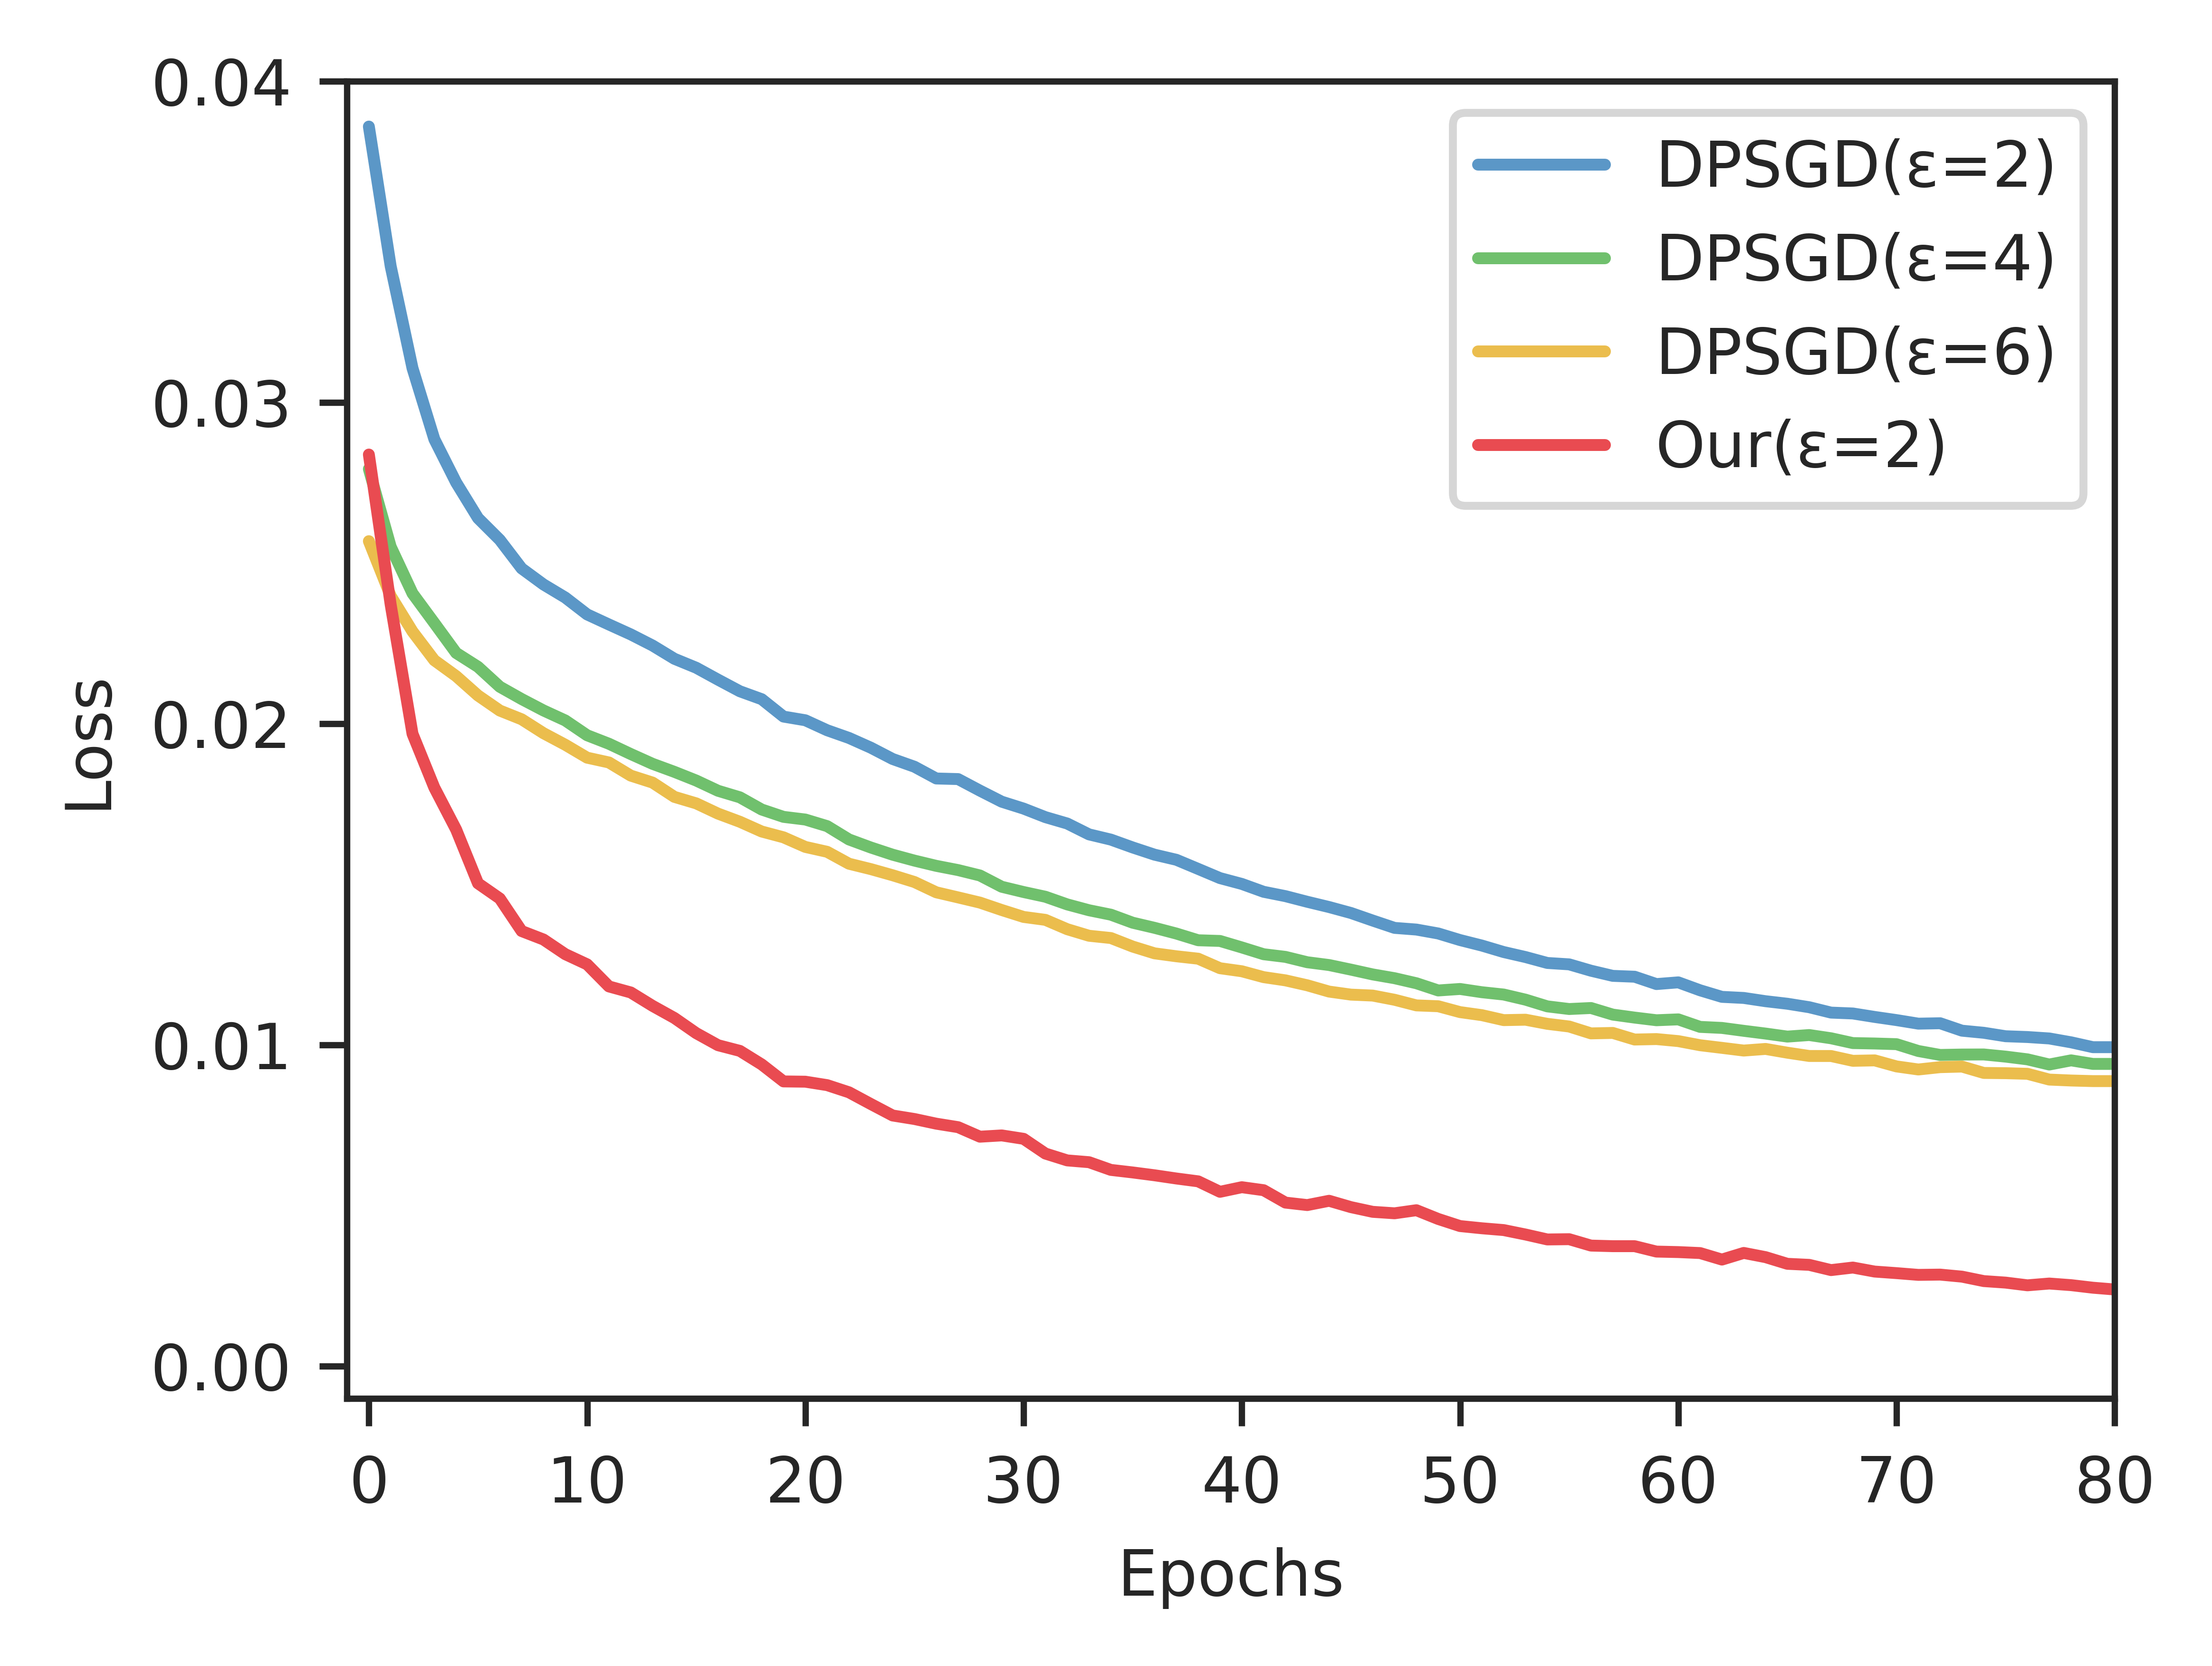

In [15]:
#svg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
from  mpl_toolkits.axisartist import axis_artist

A=np.load('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e2_loss.npy')
A=A.tolist()
A.append(A[len(A)-1])
B=np.load('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e4_loss.npy')
B=B.tolist()
B.append(B[len(B)-1])
C=np.load('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e6_loss.npy')
C=C.tolist()
C.append(C[len(C)-1])

# A=np.load('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e2_loss.npy')
# B=np.load('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e4_loss.npy')
# C=np.load('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd_e6_loss.npy')
D=np.load('/home/ysy/ysy/Fed-ReKD/zillow_our_e2_loss.npy')

# A=A.tolist()
# B=B.tolist()
# C=C.tolist()
D=D.tolist()



sns.set_style("ticks")
figure(num=None, figsize=(4, 3), dpi=1200)

plt.plot(A, '#5B97C7', label='DPSGD(ε=2)')
plt.plot(B, '#70C06D', label='DPSGD(ε=4)')
plt.plot(C, '#EBBD4D', label="DPSGD(ε=6)")
plt.plot(D, '#E94B51', label='Our(ε=2)')



plt.xticks(np.arange(0, 81, 10) , fontsize=8)
plt.yticks(np.arange(0, 0.041, 0.01),   fontsize=8)

plt.legend(loc='upper right', fontsize=8)

plt.xlabel('Epochs', fontsize=8)
plt.ylabel('Loss',  fontsize=8)

plt.xlim(-1,80)
plt.ylim(-0.001,0.04)
# plt.savefig('/home/ysy/ysy/Fed-ReKD/california_dpsgd.pdf', dpi=1200, bbox_inches="tight")
plt.savefig('/home/ysy/ysy/Fed-ReKD/zillow_dpsgd.pdf', dpi=1200, bbox_inches="tight")
plt.show()



In [ ]:
#eval  student model

for (data,target) in train_loader:
    fl_model.eval().to('cpu')
    
    pred=fl_model(data.to('cpu'))
    loss_test=loss_func(pred,target) 
print(f'student test Loss:{loss_test}',f'\n predict:{pred}',f'\n b_y:{target}')
